In [1]:
#since noteboke doesn't work in jupiterlabs    %matplotlib notebook 
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import os
# os.environ['PATH'] += os.pathsep + 'D:\\6OHDA\\'
import numpy as np
import scipy as sci
from IO import *
from utils import *
import re
from tqdm import tqdm

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Concatenate
from tensorflow.keras.layers import Convolution2D, MaxPooling2D,Conv2D, Conv1D,MaxPooling1D,LSTM
# from tensorflow.keras.layers.core import Lambda
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns

import pickle
import random
# import png

In [8]:
dir(tf.keras)

['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__']

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.config.list_physical_devices()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15179736373293113449
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10091102208
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3979507238874553930
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:17:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10091102208
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8985236072118000192
physical_device_desc: "device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
Files = ['FinalData_6OHDA.h5','FinalData_6OHDA_H.h5']
#miceList.remove('1253')
#miceList.remove('1231')
def periodCalc(day):
    if day== 0:
        return 'Healthy'
    elif day<13:
        return 'Acute' #day 1-13
    else:
        return 'Chronic' #day 14-35

cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data


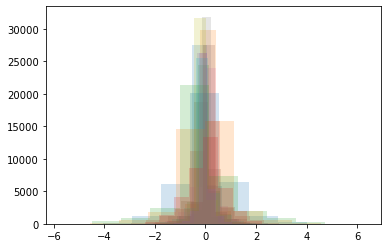

In [63]:

for m in getMiceList(Files[0]):
    data =  getData(Files[0],['speed','trace'],period ='Pre', mice=m, day=lambda x:x==0)
    dSpeed = []
    for s in data.keys():
        speed = smooth(data[s]['speed']['speed'],20)
        dSpeed.append(speed[1:]-speed[:-1])
    dSpeed = np.hstack(dSpeed)
    plt.hist(dSpeed,alpha=0.2)

In [80]:
f = h5py.File('E:\\normalized_Ca_Speed3.hdf5','a')
df = pd.DataFrame(columns= ["Mouse","Session","Period","length"])
dt = 0.05
maxSpeed = []
for m in getMiceList(Files[0]):
    data =  getData(Files[0],['speed','trace'],period ='Pre', mice=m, day=lambda x:x==0)
    for sess in data:
        speed = smooth(data[sess]['speed']['speed'],20)
        maxSpeed.append(np.max(speed))
maxSpeed = np.mean(maxSpeed)
print(maxSpeed)
for m in getMiceList(Files[0]):
    data =  getData(Files[0],['speed','trace'],period ='Pre', mice=m)
    for sess in data.keys():
        speed = data[sess]['speed']['speed']
        speed = speed/maxSpeed
        speed[speed>1] = 1
        dff = data[sess]['trace']['dff']
        mx = np.max(dff,axis = 1)
        mn = np.min(dff,axis = 1)
        dff = (dff.T-mn)/(mx-mn)
        dff = dff.T

        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        
        try:
            g = f.create_group(sess)
            g['dff'] = dff
            g['speed'] = speed
        except:
            del f[sess]
            g = f.create_group(sess)
            g['dff'] = dff
            g['speed'] = speed
        
        df = df.append({"Mouse":m,"Session":sess,'Period':periodCalc(day),"length":np.max(speed.shape),"maxN":np.min(dff.shape)},ignore_index=True)
        
df.to_csv('availableData_ca.csv')  
f.close()

cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
35.76553174529567
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trac

In [67]:
f = h5py.File('E:\\normalized_Ca_DSpeed.hdf5','a')
df = pd.DataFrame(columns= ["Mouse","Session","Period","length"])
dt = 0.05
for m in getMiceList(Files[0]):
    data =  getData(Files[0],['speed','trace'],period ='Pre', mice=m)
    for sess in data.keys():
        speed = smooth(data[sess]['speed']['speed'],20)
        speed = speed[1:]-speed[:-1]+4
        speed = ((speed-np.min(speed))/(np.max(speed)-np.min(speed)))-0.5
        dff = data[sess]['trace']['dff']
        mx = np.max(dff,axis = 1)
        mn = np.min(dff,axis = 1)
        dff = (dff.T-mn)/(mx-mn)
        dff = dff.T

        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        
        try:
            g = f.create_group(sess)
            g['dff'] = dff
            g['speed'] = speed
        except:
            del f[sess]
            g = f.create_group(sess)
            g['dff'] = dff
            g['speed'] = speed
        
        df = df.append({"Mouse":m,"Session":sess,'Period':periodCalc(day),"length":np.max(speed.shape)},ignore_index=True)
        
df.to_csv('availableData_ca.csv')  
f.close()

cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data


In [31]:
f.close()

In [6]:
miceList = getMiceList(Files[0])
miceList.remove('1253')
miceList.remove('1231')
mOrder = np.random.permutation(len(miceList))

mTrain = [1231, 1253]
mTest =[int(miceList[i]) for i in mOrder[:2]]
mTrain = mTrain+ [int(miceList[i]) for i in mOrder[2:]]

print(mTrain,mTest)
# print(miceList[mOrder[:2]])

[1231, 1253, 7909, 1793, 1222, 2980, 2976, 761, 8803, 8430, 8815, 7584, 4539, 1236] [1208, 2981]


In [7]:
def prepData(segN,overlap,df):
    df2 = df
    df2['start'] = pd.Series([[]] * len(df2), index=df2.index)
    df2['end'] = pd.Series([[]] * len(df2), index=df2.index)
    for l in df.length.unique():
        a = np.asarray([[i,i + segN] for i in range(0, l-(segN-overlap),int(segN-overlap))])
        df2.loc[df2.length==l,'start'] = pd.Series([a[:,0]] * len(df2), index=df2.index)
        df2.loc[df2.length==l,'end'] =  pd.Series([a[:,1]] * len(df2), index=df2.index)
    lst_col = 'start'

    lst_col = 'start'
    lst_col2 = 'end'
    df3 = pd.DataFrame({
        col:np.repeat(df2[col].values, df2['start'].str.len())
        for col in df2.columns.difference(['start','end'])
    }).assign(**{'start':np.concatenate(df2['start'].values)}).assign(**{'end':np.concatenate(df2['end'].values)})[df2.columns.tolist()]
    return df3

In [24]:
with h5py.File('E:\\normalized_Ca_Speed2.hdf5','r') as f:
    df['label'] = df.apply(lambda row: f[row.Session]['speed'][0,np.min([row.end,np.max(f[row.Session]['speed'].shape)-1])],axis=1  )
# df.to_csv('data_segN20_healthy.csv')

In [24]:
# df.to_csv('data_segN20_healthy.csv')

In [22]:
df.to_csv('data_segN1_healthy.csv')

In [146]:
# df = pd.read_csv('availableData_ca.csv')
# N = 100
# # try 30s with 20s overlab
# dt = 0.05
# segN = int(np.ceil(1/dt))
# overlap = segN-1
# dataSamples = prepData(segN,overlap,df)

# df = prepData(segN,overlap,df)
# df = df[(df.Period=='Healthy')&(df.maxN>=N)]
with h5py.File('E:\\normalized_Ca_Speed3.hdf5','r') as f:
    df['label'] = df.apply(lambda row: f[row.Session]['speed'][0,np.min([row.end,np.max(f[row.Session]['speed'].shape)-1])],axis=1  )
df = df[df.end<11850]

# # df['label'] = df.apply(lambda row: f[row.Session]['speed'][np.min([row.end,np.max(f[row.Session]['speed'].shape)-1])],axis=1  )
# df = pd.read_csv('data_segN20_healthy.csv')
# df = df[df.end<11850]
testData = df[df.Mouse.isin(mTest)]
trainData = df[df.Mouse.isin(mTrain)]
validate = trainData[trainData.end>(540/dt)]
trainData = trainData.drop(validate.index)
print(len(trainData),len(validate),len(testData))

344992 33568 70980


In [11]:
dataVersion = 'v1_n_ca'
#save data partition: 
trainData.to_csv('dataPartition_'+dataVersion+'_train.csv')
validate.to_csv('dataPartition_'+dataVersion+'_val.csv')
testData.to_csv('dataPartition_'+dataVersion+'_test.csv')

In [281]:
# debugging why net isn't fitting - trying a simpler dataset from a blog
dataset = pd.read_csv('E:\\NN\\LSTMtestData.csv')
dataset = dataset.values
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

def loadTrain_test(data,butchSize,N):
    # sampleSize = batchSize/3
    data = pd.DataFrame(train,columns = ['date','val'])
    minV = data.val.min()
    maxV = data.val.max()
    data['val'] = data.val.apply(lambda x: (x-minV)/(maxV-minV))
    while True: 
        #data.sample(frac=1)
        for i, g in data.iloc[N:].groupby(np.arange(len(data.iloc[N:])) // butchSize):
            batch = g
            labels = batch.apply(lambda row: data.iloc[int(row.name)-N].val if int(row.name)-N>=0 else None,axis=1 )
            labels = np.stack(labels.values)
            dataPoint = g.val.values
#             dataPoint = [np.sum(row[:,np.random.randint(0,row.shape[0],size=N)],axis=1,keepdims=True) for row in dataPoint]
            try:
                dataPoint = np.stack(dataPoint).reshape(20,1,1)
            except:
                continue
            yield (dataPoint,labels)
    f.close()

In [285]:
for ind,(dataP,label) in enumerate(loadTrain_test(train,20,5)):
    print(label.shape,dataP.shape)
    if ind == 1:
        break

(20,) (20, 1, 1)
(20,) (20, 1, 1)


In [38]:
def loadTrain_old(data,butchSize,N):
    with h5py.File('E:\\normalized_Ca_Speed2.hdf5','r') as f:
    # sampleSize = batchSize/3
        while True: 
            data = data.sample(frac=1)
            dictData = data.to_dict('records')
            labels = []
            dataPoint =[]
            for i in range(1,len(dictData)):
                labels.append(dictData[i]['label'])
                n,c = np.unique(np.sort(np.random.randint(0,f[dictData[i]['Session']]['dff'].shape[0],size=N)),return_counts=True)
                dp = np.sum(f[dictData[i]['Session']]['dff'][n,dictData[i]['start']:dictData[i]['end']].T*c,axis=1,keepdims=True)/N
                dataPoint.append(dp)
                if i%butchSize==0:# and i>0:
                    labels = np.stack(labels)
                    dataPoint = np.stack(dataPoint)
                    yield (dataPoint,labels)
                    labels = []
                    dataPoint = []


In [53]:
def loadTest_old(data,butchSize,N):
    with h5py.File('E:\\normalized_Ca_Speed2.hdf5','r') as f:
    # sampleSize = batchSize/3
        dictData = data.to_dict('records')
        labels = []
        dataPoint =[]
        for i in range(1,len(dictData)):
            labels.append(dictData[i]['label'])
            n,c = np.unique(np.sort(np.random.randint(0,f[dictData[i]['Session']]['dff'].shape[0],size=N)),return_counts=True)
            dp = np.sum(f[dictData[i]['Session']]['dff'][n,dictData[i]['start']:dictData[i]['end']].T*c,axis=1,keepdims=True)/N
            dataPoint.append(dp)
            if i%butchSize==0:# and i>0:
                labels = np.stack(labels)
                dataPoint = np.stack(dataPoint)
                yield (dataPoint,labels)
                labels = []
                dataPoint = []


In [135]:
dictData = validate.to_dict('records')
with h5py.File('E:\\normalized_Ca_Speed3.hdf5','r') as f:
    dataPoint = []
    labels = []
    for i in range(1000,4000):
        labels.append(dictData[i]['label'])
        n = np.random.permutation(f[dictData[i]['Session']]['dff'].shape[0])
        dp = f[dictData[i]['Session']]['dff'][np.sort(n[:100]),dictData[i]['start']:dictData[i]['end']].T
        dp = dp[:,np.argsort(np.mean(dp,axis=0))] #change if giving 1 timepoint
        print(dp.shape)
        dataPoint.append(dp)
        if i%butchSize==0:# and i>0:
            labels = np.stack(labels)
            dataPoint = np.stack(dataPoint)
            print(dataPoint.shape)
            labels = []
            dataPoint = []


(20, 100)
(1, 20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 10

(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)


(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)


(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)
(20, 100)


In [131]:
validate.iloc[i]

Unnamed: 0                30
Mouse                   1222
Session       1222_BaselineS
Period               Healthy
length                 11899
maxN                   111.0
start                  11163
end                    11183
label               -0.07171
Name: 368113, dtype: object

In [125]:
def loadTrain(data,butchSize,N):
    with h5py.File('E:\\normalized_Ca_Speed2.hdf5','r') as f:
    # sampleSize = batchSize/3
        while True: 
            data = data.sample(frac=1)
            dictData = data.to_dict('records')
            labels = []
            dataPoint =[]
            for i in range(1,len(dictData)):
                labels.append(dictData[i]['label'])
                n = np.random.permutation(f[dictData[i]['Session']]['dff'].shape[0])
                dp = f[dictData[i]['Session']]['dff'][np.sort(n[:100]),dictData[i]['start']:dictData[i]['end']].T
                dp = dp[:,np.argsort(np.mean(dp,axis=0))] #change if giving 1 timepoint
                dataPoint.append(dp)
                if i%butchSize==0:# and i>0:
                    labels = np.stack(labels)
                    dataPoint = np.stack(dataPoint)
                    yield (dataPoint,labels)
                    labels = []
                    dataPoint = []


In [119]:
def loadTest(data,butchSize,N):
    with h5py.File('E:\\normalized_Ca_Speed2.hdf5','r') as f:
    # sampleSize = batchSize/3
        dictData = data.to_dict('records')
        labels = []
        dataPoint =[]
        for i in range(1,len(dictData)):
            labels.append(dictData[i]['label'])
            n = np.random.permutation(f[dictData[i]['Session']]['dff'].shape[0])
            dp = f[dictData[i]['Session']]['dff'][np.sort(n[:100]),dictData[i]['start']:dictData[i]['end']].T
            dp = dp[:,np.argsort(np.mean(dp,axis=0))] #change if giving 1 timepoint
            dataPoint.append(dp)
            if i%butchSize==0:# and i>0:
                labels = np.stack(labels)
                dataPoint = np.stack(dataPoint)
                yield (dataPoint,labels)
                labels = []
                dataPoint = []


In [398]:
for ind,(dataP,label) in enumerate(loadTest(testData,butchSize,N)):
    print(label.shape,dataP.shape,np.max(dataP),np.min(dataP))
    if ind == 1:
        break

(500,) (500, 1, 1) 0.8639847756193128 0.608167288992572
(500,) (500, 1, 1) 0.737564963860034 0.5705265345124713


In [136]:
for ind,(dataP,label) in enumerate(loadTrain(validate,butchSize,N)):
    print(label.shape,dataP.shape)#,sci.stats.pearsonr(np.mean(dataP,axis=1), label))
#     plt.scatter(np.mean(dataP[:,:,0],axis=1), label)
    if ind == 16:
        break

(500,) (500, 20, 100)
(500,) (500, 20, 100)
(500,) (500, 20, 100)
(500,) (500, 20, 100)
(500,) (500, 20, 100)
(500,) (500, 20, 100)
(500,) (500, 20, 100)
(500,) (500, 20, 100)
(500,) (500, 20, 100)
(500,) (500, 20, 100)
(500,) (500, 20, 100)
(500,) (500, 20, 100)
(500,) (500, 20, 100)
(500,) (500, 20, 100)
(500,) (500, 20, 100)
(500,) (500, 20, 100)
(500,) (500, 20, 100)


In [190]:
del model  

In [175]:
butchSize = 200
N = 100

In [191]:
# model for v4
model = Sequential()
model.add(LSTM(100, input_shape=(segN, N), return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(25))
model.add(Dropout(0.2))
model.add(Dense(1))

In [192]:
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 20, 100)           80400     
_________________________________________________________________
dropout_9 (Dropout)          (None, 20, 100)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 20, 50)            30200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 20, 50)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 25)                7600      
_________________________________________________________________
dropout_11 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [498]:
import keras_tuner as kt
from keras_tuner import HyperModel as hp
from keras_tuner.tuners import RandomSearch


In [160]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse', 
    verbose=1,
    patience=450,
    mode='max',
    restore_best_weights=True)

In [204]:
modelName

'Ca2speed_v1'

In [202]:
trainData2 = trainData.sample(frac=0.1) #to run this faster, just see if we get anything
validate2 = validate.sample(1000)
modelName = 'Ca2speed_v1'

# model.compile(optimizer='sgd',
#               loss=tf.keras.losses.MeanSquaredError(),
#               metrics=['mse'])

stepTrain=len(trainData2)//butchSize #just to test something is happening
stepValidate=len(validate2)//butchSize

history = model.fit(loadTrain(trainData2,butchSize,N),
                    steps_per_epoch=stepTrain,
                    validation_data=loadTrain(validate2,butchSize,N),
                    validation_steps=stepValidate,
                    epochs=1000,callbacks=[early_stopping])#,


Epoch 1/1000
172/172 [==============================] - 104s 606ms/step - loss: 0.0913 - mse: 0.0913 - val_loss: 0.0708 - val_mse: 0.0708
Epoch 2/1000
172/172 [==============================] - 104s 608ms/step - loss: 0.0890 - mse: 0.0890 - val_loss: 0.0675 - val_mse: 0.0675
Epoch 3/1000
172/172 [==============================] - 106s 620ms/step - loss: 0.0879 - mse: 0.0879 - val_loss: 0.0703 - val_mse: 0.0703
Epoch 4/1000
172/172 [==============================] - 105s 614ms/step - loss: 0.0868 - mse: 0.0868 - val_loss: 0.0736 - val_mse: 0.0736
Epoch 5/1000
172/172 [==============================] - 106s 620ms/step - loss: 0.0864 - mse: 0.0864 - val_loss: 0.0674 - val_mse: 0.0674
Epoch 6/1000
172/172 [==============================] - 105s 614ms/step - loss: 0.0858 - mse: 0.0858 - val_loss: 0.0741 - val_mse: 0.0741
Epoch 7/1000
172/172 [==============================] - 105s 617ms/step - loss: 0.0855 - mse: 0.0855 - val_loss: 0.0704 - val_mse: 0.0704
Epoch 8/1000
172/172 [============

172/172 [==============================] - 103s 605ms/step - loss: 0.0791 - mse: 0.0791 - val_loss: 0.0728 - val_mse: 0.0728
Epoch 61/1000
172/172 [==============================] - 104s 608ms/step - loss: 0.0792 - mse: 0.0792 - val_loss: 0.0662 - val_mse: 0.0662
Epoch 62/1000
172/172 [==============================] - 103s 605ms/step - loss: 0.0794 - mse: 0.0794 - val_loss: 0.0693 - val_mse: 0.0693
Epoch 63/1000
172/172 [==============================] - 104s 610ms/step - loss: 0.0788 - mse: 0.0788 - val_loss: 0.0696 - val_mse: 0.0696
Epoch 64/1000
172/172 [==============================] - 103s 605ms/step - loss: 0.0788 - mse: 0.0788 - val_loss: 0.0670 - val_mse: 0.0670
Epoch 65/1000
172/172 [==============================] - 104s 608ms/step - loss: 0.0789 - mse: 0.0789 - val_loss: 0.0693 - val_mse: 0.0693
Epoch 66/1000
172/172 [==============================] - 104s 606ms/step - loss: 0.0789 - mse: 0.0789 - val_loss: 0.0707 - val_mse: 0.0707
Epoch 67/1000
172/172 [==================

Epoch 119/1000
172/172 [==============================] - 103s 600ms/step - loss: 0.0772 - mse: 0.0772 - val_loss: 0.0718 - val_mse: 0.0718
Epoch 120/1000
172/172 [==============================] - 102s 595ms/step - loss: 0.0769 - mse: 0.0769 - val_loss: 0.0751 - val_mse: 0.0751
Epoch 121/1000
172/172 [==============================] - 102s 599ms/step - loss: 0.0771 - mse: 0.0771 - val_loss: 0.0656 - val_mse: 0.0656
Epoch 122/1000
172/172 [==============================] - 104s 606ms/step - loss: 0.0768 - mse: 0.0768 - val_loss: 0.0658 - val_mse: 0.0658
Epoch 123/1000
172/172 [==============================] - 105s 612ms/step - loss: 0.0769 - mse: 0.0769 - val_loss: 0.0696 - val_mse: 0.0696
Epoch 124/1000
172/172 [==============================] - 104s 606ms/step - loss: 0.0765 - mse: 0.0765 - val_loss: 0.0700 - val_mse: 0.0700
Epoch 125/1000
172/172 [==============================] - 104s 608ms/step - loss: 0.0770 - mse: 0.0770 - val_loss: 0.0730 - val_mse: 0.0730
Epoch 126/1000
172/1

172/172 [==============================] - 103s 604ms/step - loss: 0.0760 - mse: 0.0760 - val_loss: 0.0655 - val_mse: 0.0655
Epoch 178/1000
172/172 [==============================] - 102s 597ms/step - loss: 0.0762 - mse: 0.0762 - val_loss: 0.0695 - val_mse: 0.0695
Epoch 179/1000
172/172 [==============================] - 103s 600ms/step - loss: 0.0760 - mse: 0.0760 - val_loss: 0.0642 - val_mse: 0.0642
Epoch 180/1000
172/172 [==============================] - 102s 596ms/step - loss: 0.0764 - mse: 0.0764 - val_loss: 0.0703 - val_mse: 0.0703
Epoch 181/1000
172/172 [==============================] - 102s 597ms/step - loss: 0.0761 - mse: 0.0761 - val_loss: 0.0658 - val_mse: 0.0658
Epoch 182/1000
172/172 [==============================] - 102s 598ms/step - loss: 0.0763 - mse: 0.0763 - val_loss: 0.0671 - val_mse: 0.0671
Epoch 183/1000
172/172 [==============================] - 102s 598ms/step - loss: 0.0761 - mse: 0.0761 - val_loss: 0.0669 - val_mse: 0.0669
Epoch 184/1000
172/172 [===========

172/172 [==============================] - 104s 605ms/step - loss: 0.0753 - mse: 0.0753 - val_loss: 0.0602 - val_mse: 0.0602
Epoch 236/1000
172/172 [==============================] - 102s 596ms/step - loss: 0.0755 - mse: 0.0755 - val_loss: 0.0705 - val_mse: 0.0705
Epoch 237/1000
172/172 [==============================] - 102s 598ms/step - loss: 0.0756 - mse: 0.0756 - val_loss: 0.0674 - val_mse: 0.0674
Epoch 238/1000
172/172 [==============================] - 103s 601ms/step - loss: 0.0755 - mse: 0.0755 - val_loss: 0.0680 - val_mse: 0.0680
Epoch 239/1000
172/172 [==============================] - 102s 598ms/step - loss: 0.0758 - mse: 0.0758 - val_loss: 0.0749 - val_mse: 0.0749
Epoch 240/1000
172/172 [==============================] - 102s 597ms/step - loss: 0.0758 - mse: 0.0758 - val_loss: 0.0698 - val_mse: 0.0698
Epoch 241/1000
172/172 [==============================] - 103s 603ms/step - loss: 0.0754 - mse: 0.0754 - val_loss: 0.0688 - val_mse: 0.0688
Epoch 242/1000
172/172 [===========

172/172 [==============================] - 104s 610ms/step - loss: 0.0750 - mse: 0.0750 - val_loss: 0.0691 - val_mse: 0.0691
Epoch 294/1000
172/172 [==============================] - 103s 603ms/step - loss: 0.0747 - mse: 0.0747 - val_loss: 0.0753 - val_mse: 0.0753
Epoch 295/1000
172/172 [==============================] - 104s 608ms/step - loss: 0.0751 - mse: 0.0751 - val_loss: 0.0682 - val_mse: 0.0682
Epoch 296/1000
172/172 [==============================] - 103s 602ms/step - loss: 0.0752 - mse: 0.0752 - val_loss: 0.0722 - val_mse: 0.0722
Epoch 297/1000
172/172 [==============================] - 103s 600ms/step - loss: 0.0749 - mse: 0.0749 - val_loss: 0.0652 - val_mse: 0.0652
Epoch 298/1000
172/172 [==============================] - 102s 598ms/step - loss: 0.0748 - mse: 0.0748 - val_loss: 0.0686 - val_mse: 0.0686
Epoch 299/1000
172/172 [==============================] - 103s 603ms/step - loss: 0.0749 - mse: 0.0749 - val_loss: 0.0638 - val_mse: 0.0638
Epoch 300/1000
172/172 [===========

172/172 [==============================] - 104s 610ms/step - loss: 0.0748 - mse: 0.0748 - val_loss: 0.0664 - val_mse: 0.0664
Epoch 352/1000
172/172 [==============================] - 103s 603ms/step - loss: 0.0746 - mse: 0.0746 - val_loss: 0.0792 - val_mse: 0.0792
Epoch 353/1000
172/172 [==============================] - 104s 607ms/step - loss: 0.0747 - mse: 0.0747 - val_loss: 0.0684 - val_mse: 0.0684
Epoch 354/1000
172/172 [==============================] - 104s 606ms/step - loss: 0.0746 - mse: 0.0746 - val_loss: 0.0711 - val_mse: 0.0711
Epoch 355/1000
172/172 [==============================] - 104s 608ms/step - loss: 0.0743 - mse: 0.0743 - val_loss: 0.0728 - val_mse: 0.0728
Epoch 356/1000
172/172 [==============================] - 103s 604ms/step - loss: 0.0745 - mse: 0.0745 - val_loss: 0.0695 - val_mse: 0.0695
Epoch 357/1000
172/172 [==============================] - 104s 610ms/step - loss: 0.0746 - mse: 0.0746 - val_loss: 0.0730 - val_mse: 0.0730
Epoch 358/1000
172/172 [===========

172/172 [==============================] - 104s 610ms/step - loss: 0.0738 - mse: 0.0738 - val_loss: 0.0715 - val_mse: 0.0715
Epoch 410/1000
172/172 [==============================] - 104s 605ms/step - loss: 0.0742 - mse: 0.0742 - val_loss: 0.0744 - val_mse: 0.0744
Epoch 411/1000
172/172 [==============================] - 104s 607ms/step - loss: 0.0744 - mse: 0.0744 - val_loss: 0.0739 - val_mse: 0.0739
Epoch 412/1000
172/172 [==============================] - 104s 607ms/step - loss: 0.0741 - mse: 0.0741 - val_loss: 0.0687 - val_mse: 0.0687
Epoch 413/1000
172/172 [==============================] - 104s 607ms/step - loss: 0.0742 - mse: 0.0742 - val_loss: 0.0745 - val_mse: 0.0745
Epoch 414/1000
172/172 [==============================] - 103s 605ms/step - loss: 0.0739 - mse: 0.0739 - val_loss: 0.0759 - val_mse: 0.0759
Epoch 415/1000
172/172 [==============================] - 104s 610ms/step - loss: 0.0743 - mse: 0.0743 - val_loss: 0.0696 - val_mse: 0.0696
Epoch 416/1000
172/172 [===========

172/172 [==============================] - 103s 601ms/step - loss: 0.0739 - mse: 0.0739 - val_loss: 0.0719 - val_mse: 0.0719
Epoch 468/1000
172/172 [==============================] - 103s 600ms/step - loss: 0.0737 - mse: 0.0737 - val_loss: 0.0648 - val_mse: 0.0648
Epoch 469/1000
172/172 [==============================] - 102s 599ms/step - loss: 0.0739 - mse: 0.0739 - val_loss: 0.0779 - val_mse: 0.0779
Epoch 470/1000
172/172 [==============================] - 103s 603ms/step - loss: 0.0736 - mse: 0.0736 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 471/1000
172/172 [==============================] - 105s 612ms/step - loss: 0.0738 - mse: 0.0738 - val_loss: 0.0705 - val_mse: 0.0705
Epoch 472/1000
172/172 [==============================] - 103s 604ms/step - loss: 0.0736 - mse: 0.0736 - val_loss: 0.0710 - val_mse: 0.0710
Epoch 473/1000
172/172 [==============================] - 105s 612ms/step - loss: 0.0738 - mse: 0.0738 - val_loss: 0.0648 - val_mse: 0.0648
Epoch 474/1000
172/172 [===========

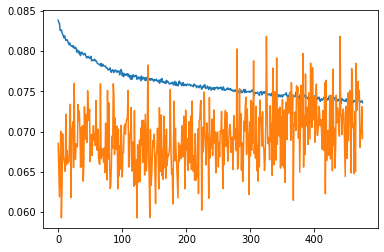

In [203]:
plt.plot(history.history['loss'][10:])

plt.plot(history.history['val_loss'][10:])# history.history
# plt.savefig("E:\\NN\\"+modelName+"_history.png")

In [205]:
## Saving the model
##
model.save('E:\\'+modelName)
model.save_weights('E:\\'+modelName+'_weights.h5')

INFO:tensorflow:Assets written to: E:\Ca2speed_v1\assets


INFO:tensorflow:Assets written to: E:\Ca2speed_v1\assets


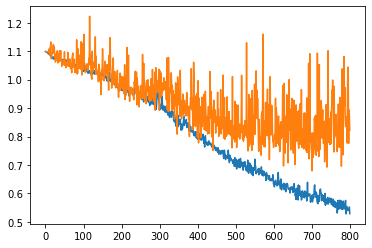

In [479]:
plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])# history.history
plt.legend.show()
plt.savefig("E:\\NN\\LSTM_"+modelName+"_loss.png")

In [50]:
def loadLabel(data,butchSize,N):
    f = h5py.File('E:\\normalized_Ca_Speed.hdf5','r')
    # sampleSize = batchSize/3
    dictData = data.to_dict('records')
    labels = []
    for i in range(1,len(dictData)):
        labels.append(dictData[i]['label'])
        if i%butchSize==0:
            labels = np.stack(labels)
            yield (labels)
            labels = []
    f.close()


354/354 [==============================] - 192s 543ms/step


(0.0, 1.0)

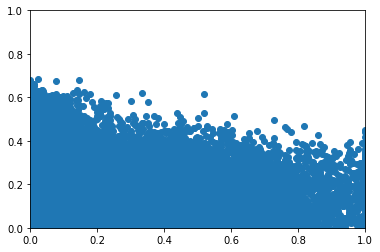

In [212]:
# model =  tf.keras.models.load_model('E:\\caOnly_v1')
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model.load_weights("E:\\caOnly_v1_weights.h5")
testData2 = testData
# testData2
y_hat = model.predict(loadTest(testData2,butchSize,N),verbose=1)

y = []
for ind,(label) in enumerate(loadLabel(testData2,butchSize,N)):
    y = y+list(label)

plt.scatter(y,y_hat)
plt.xlim(0, 1)
plt.ylim(0, 1)

In [213]:
# %matplotlib inline
# plt.plot(y[:400])
# plt.plot(y_hat[:400]*10-1.5)
sci.stats.pearsonr(np.asarray(y_hat,dtype='float')[:,0], np.asarray(y, dtype='float'))
# np.asarray(y_hat, dtype='float')[:,0].shape

(-0.10005891835617789, 6.071264233167835e-157)

172/172 [==============================] - 98s 574ms/step


(0.0, 1.0)

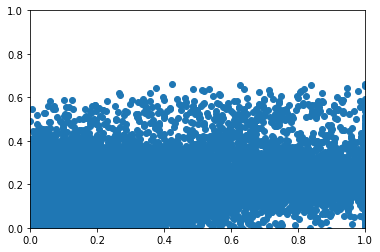

In [208]:
# model =  tf.keras.models.load_model('E:\\caOnly_v1')
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model.load_weights("E:\\caOnly_v1_weights.h5")
# trainData3 = trainData2.iloc[:1000,]
# testData2
y_hat = model.predict(loadTest(trainData2,butchSize,N),verbose=1)

y = []
for ind,(label) in enumerate(loadLabel(trainData2,butchSize,N)):
    y = y+list(label)

plt.scatter(y,y_hat)
plt.xlim(0, 1)
plt.ylim(0, 1)


In [209]:
# %matplotlib inline
# plt.plot(y[:400])
# plt.plot(y_hat[:400]*10-1.5)
sci.stats.pearsonr(np.asarray(y_hat,dtype='float')[:,0], np.asarray(y, dtype='float'))
# np.asarray(y_hat, dtype='float')[:,0].shape

(0.3930213592678637, 0.0)

4/4 [==============================] - 2s 768ms/step


(0.0, 1.0)

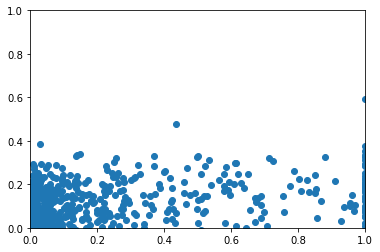

In [210]:
# model =  tf.keras.models.load_model('E:\\caOnly_v1')
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model.load_weights("E:\\caOnly_v1_weights.h5")
# trainData3 = trainData2.iloc[:1000,]
# testData2
y_hat = model.predict(loadTest(validate2,butchSize,N),verbose=1)

y = []
for ind,(label) in enumerate(loadLabel(validate2,butchSize,N)):
    y = y+list(label)

plt.scatter(y,y_hat)
plt.xlim(0, 1)
plt.ylim(0, 1)


In [211]:
# %matplotlib inline
# plt.plot(y[:400])
# plt.plot(y_hat[:400]*10-1.5)
sci.stats.pearsonr(np.asarray(y_hat,dtype='float')[:,0], np.asarray(y, dtype='float'))
# np.asarray(y_hat, dtype='float')[:,0].shape

(0.42187784393892547, 7.261427767166929e-36)

In [135]:
# N = 9
# dictdf = testData2.to_dict('records')
# for i in range(0,18,N):
#     print(pd.DataFrame(dictdf[i:i+N]),i,i+N)
f = h5py.File('E:\\normalized_Ca_Speed.hdf5','r')
trainData2['label'] = trainData2.apply(lambda row: f[row.Session]['speed'][np.min([row.end,np.max(f[row.Session]['speed'].shape)-1])],axis=1  )
f.close()

In [341]:
def loadTrainLabel(data,butchSize,N):
    f = h5py.File('E:\\normalized_Ca_Speed.hdf5','r')
    # sampleSize = batchSize/3
    dictData = data.to_dict('records')
    labels = []
    for i in range(1,len(dictData)):
        labels.append(dictData[i]['label'])
        if i%butchSize==0:
            labels = np.stack(labels)
            yield (labels)
            labels = []
    f.close()

def loadTrain2(data,butchSize,N):
    f = h5py.File('E:\\normalized_Ca_Speed.hdf5','r')
    # sampleSize = batchSize/3
#     while True: 
    data.sample(frac=1)
    dictData = data.to_dict('records')
    labels = []
    dataPoint =[]
    for i in range(len(dictData)):
        labels.append(dictData[i]['label'])
        dp = f[dictData[i]['Session']]['dff'][:,dictData[i]['start']:dictData[i]['end']].T
        dp = np.mean(dp[:,np.random.randint(0,dp.shape[0],size=N)],keepdims=True)
        dataPoint.append(dp)
        if i%butchSize==0 and i>0:
            labels = np.stack(labels)
            dataPoint = np.stack(dataPoint)
            yield (dataPoint,labels)
            labels = []
            dataPoint = []
    f.close()

    
    
def loadTrain(data,butchSize,N):
    f = h5py.File('E:\\normalized_Ca_Speed.hdf5','r')
    # sampleSize = batchSize/3
#     while True: 
    data.sample(frac=1)
    for i, g in data.groupby(np.arange(len(data)) // butchSize):
        batch = g
        labels = batch.label
        labels = np.stack(labels.values)
        dataPoint = batch.apply(lambda row: f[row.Session]['dff'][:,row.start:row.end].T, axis=1).values
        dataPoint = [np.mean(row[:,np.random.randint(0,row.shape[0],size=N)],axis=1,keepdims=True) for row in dataPoint]
        try:
            dataPoint = np.stack(dataPoint)
        except:
            continue
        yield (dataPoint,labels)
    f.close()

     
   

y = []
for ind,(dataP,label) in tqdm(enumerate(loadTrain2(trainData2.iloc[:100000],10,N))):
    y = y+list(label)

y = []
for ind,(dataP,label) in tqdm(enumerate(loadTrain(trainData2.iloc[:100000],10,N))):
    y = y+list(label)


# plt.plot(y)

9999it [07:25, 22.46it/s]
10000it [07:34, 22.01it/s]


In [387]:
def loadTrain3(data,butchSize,N):
    with h5py.File('E:\\normalized_Ca_Speed.hdf5','r') as f:
    # sampleSize = batchSize/3
#     while True: 
        data.sample(frac=1)
        dictData = data.to_dict('records')
        labels = []
        dataPoint =[]
        for i in range(len(dictData)):
            labels.append(dictData[i]['label'])
            n,c = np.unique(np.sort(np.random.randint(0,f[dictData[i]['Session']]['dff'].shape[0],size=N)),return_counts=True)
            dp = np.sum(f[dictData[i]['Session']]['dff'][n,dictData[i]['start']:dictData[i]['end']].T*c,axis=1,keepdims=True)/N
            dataPoint.append(dp)
            if i%butchSize==0 and i>0:
                labels = np.stack(labels)
                dataPoint = np.stack(dataPoint)
                yield (dataPoint,labels)
                labels = []
                dataPoint = []
    
y = []
for ind,(dataP,label) in tqdm(enumerate(loadTrain3(trainData2.iloc[:100000],10,N))):
    y = y+list(label)


9999it [03:44, 44.55it/s]


In [380]:
with h5py.File('E:\\normalized_Ca_Speed.hdf5','r') as f: 
    n = np.sort(np.random.randint(0,f[dictData[i]['Session']]['dff'].shape[0],size=N))
    n,c = np.unique(n,return_counts=True)
    print(f[dictData[i]['Session']]['dff'][n,:].T*c)

[[0.73899053 0.68311337 0.28387812 ... 0.41127712 0.46345011 0.32855268]
 [0.74808939 0.68733521 0.29657809 ... 0.42558941 0.44989046 0.31903619]
 [0.74468246 0.7056513  0.28962509 ... 0.44181902 0.46635848 0.3324495 ]
 ...
 [0.02433376 0.02971494 0.18222508 ... 0.02073476 0.02753908 0.02340979]
 [0.02077163 0.03944054 0.19441334 ... 0.00972384 0.         0.01699147]
 [0.01643481 0.03631539 0.20808202 ... 0.01158879 0.02376598 0.0125454 ]] [1 1 1 2 1 1 2 1 1 2 1 1 1 1 1 1 1 2 1 3 1 3 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 3 3 1 2 1 1 4 1 1 1 1 1 2 1 1 1 1
 1 1 2 1]
